# Индификация пользователя по статистике его веб-серфинга

## Задача: индифицировать пользователя по цепочки посещенных сайтов
Каждый человек индивидуален и его поведение в жизни и в интернете то же. Встает вопрос можно ли эту индивидуальность выявить и использовать?Дальше мы попробуем выявить индивидулаьные черты пользователя при веб-серфинге и используем их для его идентификации. За основу возьмем данне с прокси-серверов Университета Блеза Паскаля. Решение этой задачи поможет компаниям вроде Google и Yandex повысить безопасность пользовательских аккаунтов и оперативно выявлять взломы. 

In [86]:
#Импортируем необходимые библиотеки
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import itertools
import scipy.stats as stats
import scipy.sparse as sp
from statsmodels.stats.proportion import proportion_confint
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, normalize

%pylab inline
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


In [3]:
#Путь к данным
PATH_TO_DATA = ('C:\\Users\\Raven\\Downloads\\yandex_final\\')

##  1. Exploratory data analysis (EDA)

Данные доступны в виде набора CSV файлов. Сформированых по принципу 1 пользователь - 1 файл. Считаем один файл и посмотрим на содержимое.

In [3]:
data = pd.read_csv(os.path.join(PATH_TO_DATA,'10users/user0031.csv'))
data.head()

,timestamp,site
0,2013-11-15 08:12:07,fpdownload2.macromedia.com
1,2013-11-15 08:12:17,laposte.net
2,2013-11-15 08:12:17,www.laposte.net
3,2013-11-15 08:12:17,www.google.com
4,2013-11-15 08:12:18,www.laposte.net


Файл содержит сайт и время его посещения. Файл мы загрузили в PandasDataFrame. Воспользуемся встроенымы методами .info(), describe() чтобы сформировать описательные статистики.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 2 columns):
timestamp    7600 non-null object
site         7600 non-null object
dtypes: object(2)
memory usage: 118.8+ KB


In [5]:
data.describe()

,timestamp,site
count,7600,7600
unique,4321,962
top,2014-03-20 11:02:20,webmail.laposte.net
freq,20,399


Для этого пользователя у нас есть 7600 записей. Уникальных сайтов 962. Пропусков в данных нет. Самый посещаемый сайт webmail.laposte.net

In [6]:
print("Все записи лежат в интервале от {} до {}".format(data.timestamp.min(), data.timestamp.max()))

Все записи лежат в интервале от 2013-11-15 08:12:07 до 2014-03-28 13:09:07


Для дальнейшей работы соберем все записи в один DataFrame вида:
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{font-family:Arial, sans-serif;font-size:14px;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg th{font-family:Arial, sans-serif;font-size:14px;font-weight:normal;padding:10px 5px;border-style:solid;border-width:1px;overflow:hidden;word-break:normal;}
.tg .tg-s6z2{text-align:center}
.tg .tg-baqh{text-align:center;vertical-align:top}
.tg .tg-hgcj{font-weight:bold;text-align:center}
.tg .tg-amwm{font-weight:bold;text-align:center;vertical-align:top}
</style>
<table class="tg">
  <tr>
    <th class="tg-hgcj">session_id</th>
    <th class="tg-hgcj">site1</th>
    <th class="tg-hgcj">site2</th>
    <th class="tg-amwm">user_id</th>
  </tr>
  <tr>
    <td class="tg-s6z2">1</td>
    <td class="tg-s6z2">1</td>
    <td class="tg-s6z2">2</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-s6z2">2</td>
    <td class="tg-s6z2">1</td>
    <td class="tg-s6z2">3</td>
    <td class="tg-baqh">1</td>
  </tr>
  <tr>
    <td class="tg-s6z2">3</td>
    <td class="tg-s6z2">3</td>
    <td class="tg-s6z2">2</td>
    <td class="tg-baqh">2</td>
  </tr>
  <tr>
    <td class="tg-s6z2">4</td>
    <td class="tg-s6z2">4</td>
    <td class="tg-s6z2">3</td>
    <td class="tg-baqh">2</td>
  </tr>
</table>

Предусмотрем возможность выбора длины сессии и шага окна. В дальнейшем надо будет подбирать оптимальную длину сессии и шаг.
Сайты закодируем индексами и сделаем словарь индексов.

In [4]:
# Определим функцию для формирования словаря частот
def read_users(path):
    lst = []
    for f in glob.glob(path): 
        lst.append(pd.read_csv(f))
    
    frq_dict = {}
    data = pd.concat(lst).reset_index()
    sites, counts = np.unique(data['site'], return_counts=True)
    sort = sorted(zip(counts, sites), key=lambda x:x[0], reverse=True)
    for i in range(len(sort)):
        frq_dict[sort[i][1]] = i
    
    return frq_dict

# Определим функцию для формирования DataFrame
def prepare_train_set_window(path_to_csv_files, x_dict, feature_names, session_length=10, window_size=10):
    
    
    session,y = [],[]
    for f in glob.glob(path_to_csv_files):
        user_id = int(str(re.findall('user[0-9]{4}.csv', f)[0])[4:8])
        data = pd.read_csv(f, parse_dates=['timestamp'])
        dlina = len(data)
        s=0        
        while dlina > 0:            
            srez = data.iloc[s:s+session_length]            
             
            sites=[]
            for stroka in srez.iterrows():                  
                sites.append(int(x_dict[stroka[1]['site']]))            
            
            y.append(user_id)             
            n = session_length - len(sites)           
            if n > 0:
                sites = sites + [0]*n
             
            session.append(sites + [user_id])
            s += window_size
            dlina -= window_size
            
    df = pd.DataFrame(session)
    df.columns = feature_names
    return df

In [5]:
# Формируем словарь
f_dict = read_users(os.path.join(PATH_TO_DATA,'10users\\*.csv'))

In [6]:
# Формируем датафрейм сдлиной сессии 10 и окном 10
df = prepare_train_set_window(os.path.join(PATH_TO_DATA,'10users\\*.csv'), f_dict, \
                         ['site' + str(i) for i in range(1,11)] + ['user_id'])

Посчитаем число уникальных сайтов в сессии и построим гистограму их распределения

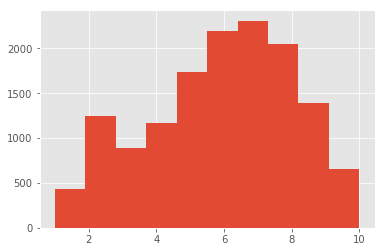

In [111]:
num_unique_sites = [np.unique(df.values[i, :-1]).shape[0] 
                    for i in range(df.shape[0])]
pd.Series(num_unique_sites).hist()

Проверим распределение уникальных сайтов на нормальность

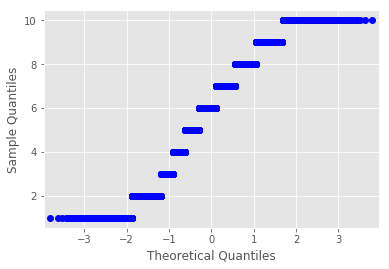

In [112]:
qqplot(np.array(num_unique_sites), dist="norm")
plt.show()

На графики видны тежелые хвосты это говорит о том что распределение не является нормальным. Проверим это дополнительнос помощью критерия Шапиро-Уилка

In [12]:
print('Критерий Шапиро - Уилка : {}'.format(stats.shapiro(num_unique_sites)[0]))

Критерий Шапиро - Уилка : 0.954693317413


Теперь проверим гипотезу что пользователь заходит на один и тот же сайт несколько раз в течении одной сессии. Для этого используем биномиальный критерий для доли. Предположим  что доля случаев, когда пользователь повторно посетил какой-то сайт велика: больше 95%. То есть число уникальных сайтов в сессии < 10 в 95% или более процентах случаев.

In [13]:
has_two_similar = (np.array(num_unique_sites) < 10).astype('int')
pi_val = stats.binom_test(sum(has_two_similar), len(has_two_similar),  p=0.95, alternative = 'greater')
print('P-value: {}'.format(pi_val))

P-value: 0.0220765376907


Построим доверительный интервал для этой доли

In [14]:
wilson_interval = proportion_confint(sum(has_two_similar), len(has_two_similar), method = 'wilson')
print('Доверительный интервал Вилсона: {}'.format(wilson_interval))

Доверительный интервал Вилсона: (0.95010288414112865, 0.95705273772322286)


На этом мы закончим знакомство с данными и перейдем к подготовки данных для обучения моделей

# 2. Подготовка данных и обучение простых моделей

Мы будем использовать линейные модели из пакета sklearn. Они не могут работать с даными в виде DataFrama  поэтому для их обучения надо привести данные к разреженому формату Compressed Sparse Row matrix. Определим для этого функцию.

In [10]:
def matrix(df):
    
    data = []
    row = []
    col = []

    for i, session in enumerate(df):
        for site in session:
            site = int(site)
            if site == 0:
                continue

            data.append(1)
            row.append(i)
            col.append(site - 1)
    
    return sp.csr_matrix((data, (row, col)))

In [11]:
# Отделим Выделим ответы в отдельный массив
y= df['user_id']
X = df.drop('user_id', axis=1)

In [12]:
# Переведем DataFrame в разреженый формат
X_sparse = matrix(X.values)

Разделим данные на обучение и тест

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y)

Для проверки качества моделей будем использовать кросс-валидацию

In [14]:
skf = StratifiedKFold(n_splits=3, shuffle=False, random_state=17)

Определим функцию для отрисовки кривых обучения

In [5]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

Для начала попробуем метод К- ближайших соседей

In [13]:
knn = KNeighborsClassifier(n_jobs = -1)

In [14]:
%%time
print('Результат К-ближайших соседей: {}'.format(cross_val_score(knn, X_train, y_train, cv = skf).mean()))

Результат К-ближайших соседей: 0.598457200838
Wall time: 8.31 s


Попробуем подобрать гиперпараметры для более точной настройки модели, в данном случае это К-количество соседей, будем использовать поиск по сетке. Так же построим кривую обучения и проверим результат на отложеной выборке.

In [15]:
%%time
k = [3, 4, 5, 30, 100]
knn_params = {'n_neighbors': k}

knn_grid_search = GridSearchCV(knn, knn_params, cv=skf, n_jobs=3)
knn_grid_search.fit(X_train, y_train)

Wall time: 0 ns


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=False),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'n_neighbors': [3, 4, 5, 30, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [16]:
print('Лучший результат: {}, получен при К = {}'.format(knn_grid_search.best_score_, knn_grid_search.best_params_))

Лучший результат: 0.608514529567, получен при К = {'n_neighbors': 3}


In [17]:
print('Результат на отложеной выборке {}'.format(accuracy_score(y_valid, knn_grid_search.best_estimator_.predict(X_valid))))

Результат на отложеной выборке 0.635221616497


Построим кривую обучения

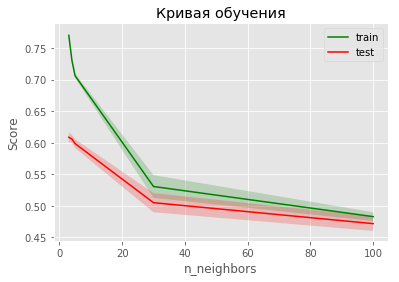

In [20]:
plot_validation_curves(k, knn_grid_search.cv_results_)
plt.xlabel('n_neighbors')
plt.ylabel('Score')
plt.title(u'Кривая обучения')

Попробуем случайный лес

In [21]:
tree = RandomForestClassifier(random_state = 17, oob_score = True, n_jobs = 3)

In [22]:
%%time
print('Результат случайного леса: {}'.format(cross_val_score(tree, X_train, y_train, cv = skf).mean()))

Результат случайного леса: 0.665310703527
Wall time: 3.62 s


Для случайного леса так же попробуем провести подбор параметров

In [23]:
%%time
tree_params = {'n_estimators': [100, 500, 1000],
              'min_samples_split': [2, 5, 7]}

tree_grid_search = GridSearchCV(tree, tree_params, cv=skf, n_jobs=3)
tree_grid_search.fit(X_train, y_train)

Wall time: 0 ns


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=3, oob_score=True, random_state=17,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'n_estimators': [100, 500, 1000], 'min_samples_split': [2, 5, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [24]:
print('Лучший результат: {}, получен при {}'.format(tree_grid_search.best_score_, tree_grid_search.best_params_))

Лучший результат: 0.711440764072, получен при {'min_samples_split': 5, 'n_estimators': 1000}


In [25]:
print('Результат на отложеной выборке {}'.format(accuracy_score(y_valid, tree_grid_search.best_estimator_.predict(X_valid))))

Результат на отложеной выборке 0.731926996919


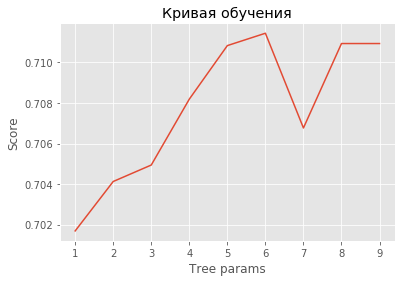

In [26]:
plt.plot(range(1,10), tree_grid_search.cv_results_['mean_test_score'])
plt.xlabel('Tree params')
plt.ylabel('Score')
plt.title(u'Кривая обучения')

И попробуем логистическую регрессию

In [15]:
logreg = LogisticRegression(random_state = 17, n_jobs = 3)

In [ ]:
%%time
print('Результат регрессии: {}'.format(cross_val_score(logreg, X_train, y_train, cv = skf).mean()))

In [16]:
%%time
logreg_c = np.linspace(0.1, 8, 30)
logreg_params = {'C': logreg_c}

logreg_grid_search = GridSearchCV(logreg, logreg_params, cv=skf, n_jobs=3)
logreg_grid_search.fit(X_train, y_train)

Wall time: 42.4 s


In [31]:
print('Лучший результат: {}, получен при {}'.format(logreg_grid_search.best_score_, logreg_grid_search.best_params_))

Лучший результат: 0.759906523064, получен при {'C': 1.4620689655172414}


In [32]:
print('Результат на отложеной выборке {}'.format(accuracy_score(y_valid, logreg_grid_search.best_estimator_.predict(X_valid))))

Результат на отложеной выборке 0.780516710121


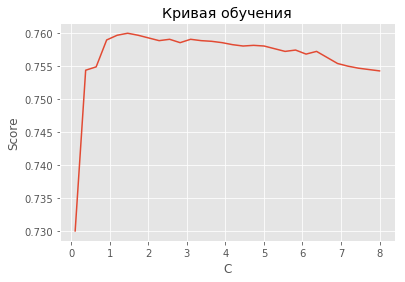

In [33]:
plt.plot(logreg_c, logreg_grid_search.cv_results_['mean_test_score'])
plt.xlabel('C')
plt.ylabel('Score')
plt.title(u'Кривая обучения')

Попробуем LinearSVC

In [36]:
svm = LinearSVC(random_state=17)

In [37]:
%%time
print('Результат LinearSVC: {}'.format(cross_val_score(svm, X_train, y_train, cv = skf).mean()))

Результат LinearSVC: 0.74974576454
Wall time: 7.08 s


In [38]:
%%time
svm_c = np.linspace(0.001, 0.2, 10)
svm_params = {'C': svm_c}

svm_grid_search = GridSearchCV(svm, svm_params, cv=skf, n_jobs=3)
svm_grid_search.fit(X_train, y_train)

Wall time: 0 ns


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=False),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'C': array([ 0.001  ,  0.02311,  0.04522,  0.06733,  0.08944,  0.11156,
        0.13367,  0.15578,  0.17789,  0.2    ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [39]:
print('Лучший результат: {}, получен при {}'.format(svm_grid_search.best_score_, svm_grid_search.best_params_))

Лучший результат: 0.763970737655, получен при {'C': 0.11155555555555556}


In [40]:
print('Результат на отложеной выборке {}'.format(accuracy_score(y_valid, svm_grid_search.best_estimator_.predict(X_valid))))

Результат на отложеной выборке 0.777672434226


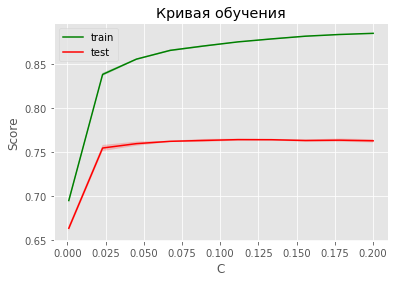

In [43]:
plot_validation_curves(svm_c, svm_grid_search.cv_results_)
plt.xlabel('C')
plt.ylabel('Score')
plt.title(u'Кривая обучения')

В целом результаты моделей достаточно близки. Некоторые показав меньшую точность значительно выигрывают в скорости и на большом обьеме данных это может стать критичным.
Теперь попробуем подобрать более оптимальную ширину окна и количество сайтов в сессии. Сначала пройдемся по разным вариантам ширины и длины и сохраним их в PKL формате.

In [ ]:
for num_users in [10, 150]:
    
    for window_size, session_length in itertools.product([15, 10, 5], [15, 10, 7, 5]):
        
        if window_size <= session_length:
            X_sparse, y = prepare_sparse_train_set_window(os.path.join(PATH_TO_DATA, str(num_users)+'users'), 
                                                       os.path.join(PATH_TO_DATA, 'site_freq_'+str(num_users)+'users.pkl'),
                                       session_length=session_length, window_size=window_size)
            
            with open(os.path.join(PATH_TO_DATA, 
                                   'X_sparse_'+str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl'), 
                      'wb') as X_pkl:
                pickle.dump(X_sparse, X_pkl, protocol=2)
                
            with open(os.path.join(PATH_TO_DATA, 
                       'y_'+str(num_users)+'users_s'+str(session_length)+'_w'+str(window_size)+'.pkl'), 
                      'wb') as y_pkl:
                pickle.dump(y, y_pkl, protocol=2) 

Определим функцию которая будет считывать наши файлы и подсчитывать точность в зависимости от разных ширины и длины окна

In [6]:
def model_assessment(estimator, path_to_X_pickle, path_to_y_pickle, cv, random_state=17, test_size=0.3):
    '''
    Estimates CV-accuracy for (1 - test_size) share of (X_sparse, y) 
    loaded from path_to_X_pickle and path_to_y_pickle and holdout accuracy for (test_size) share of (X_sparse, y).
    The split is made with stratified train_test_split with params random_state and test_size.
    
    :param estimator – Scikit-learn estimator (classifier or regressor)
    :param path_to_X_pickle – path to pickled sparse X (instances and their features)
    :param path_to_y_pickle – path to pickled y (responses)
    :param cv – cross-validation as in cross_val_score (use StratifiedKFold here)
    :param random_state –  for train_test_split
    :param test_size –  for train_test_split
    
    :returns mean CV-accuracy for (X_train, y_train) and accuracy for (X_valid, y_valid) where (X_train, y_train)
    and (X_valid, y_valid) are (1 - test_size) and (testsize) shares of (X_sparse, y).
    '''
    with open(path_to_X_pickle, 'rb') as X10_pkl:
        X_sparse = pickle.load(X10_pkl) 
        
    with open(path_to_y_pickle, 'rb') as X10_pkl:
        y_users = pickle.load(X10_pkl) 

    X_train, X_valid, y_train, y_valid = train_test_split(X_sparse, y_users, test_size=0.3, 
                                                     random_state=17, stratify=y_users)
    
    scores = cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=3)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred)
    return np.mean(scores), acc

В качестве модели будем использовать логистическую регрессию с лучшими найдеными гиперпараметрами

In [26]:
estimator = logreg_grid_search.best_estimator_

In [58]:
%%time
for window_size, session_length in itertools.product([10, 7, 5], [15, 10, 7, 5]):
    name_x = 'x_sparse_' + str(10) + 'usr'+ str(session_length) + '_w' + str(window_size) +'.pkl'
    name_y = 'y_' + str(10) + 'usr'+ str(session_length) + '_w' + str(window_size) +'.pkl'
    if window_size <= session_length:
        path_to_X_pkl = os.path.join(PATH_TO_DATA, name_x)
        path_to_y_pkl = os.path.join(PATH_TO_DATA, name_y)
        res = model_assessment(estimator, path_to_X_pkl, path_to_y_pkl, skf, random_state=17, test_size=0.3)
        print ('Длина сессии {} сайтов и ширина окна {} сайтов'.format(session_length, window_size))
        print ('Результат на кросс-валидации {}, результат на отложенной выборке {}'.format(res[0], res[1]))

Длина сессии 15 сайтов и ширина окна 10 сайтов
Результат на кросс-валидации 0.824119750058, результат на отложенной выборке 0.841668641858
Длина сессии 10 сайтов и ширина окна 10 сайтов
Результат на кросс-валидации 0.763361246306, результат на отложенной выборке 0.783835031998
Длина сессии 15 сайтов и ширина окна 7 сайтов
Результат на кросс-валидации 0.85021459936, результат на отложенной выборке 0.853492616559
Длина сессии 10 сайтов и ширина окна 7 сайтов
Результат на кросс-валидации 0.800497944773, результат на отложенной выборке 0.807532769205
Длина сессии 7 сайтов и ширина окна 7 сайтов
Результат на кросс-валидации 0.752775559576, результат на отложенной выборке 0.761738841878
Длина сессии 15 сайтов и ширина окна 5 сайтов
Результат на кросс-валидации 0.86759481405, результат на отложенной выборке 0.878022759602
Длина сессии 10 сайтов и ширина окна 5 сайтов
Результат на кросс-валидации 0.817652758709, результат на отложенной выборке 0.830251303936
Длина сессии 7 сайтов и ширина окна

Похоже что лучший результат достигается при длине сессии в 15 сайтов и ширене окна 5 сайтов. Сформируем DataFrame с новыми параметрами и дальше будем использовать его. 

In [27]:
# Формируем датафрейм сдлиной сессии 15 и окном 5
df_15_5 = prepare_train_set_window(os.path.join(PATH_TO_DATA,'10users\\*.csv'), f_dict, \
                         ['site' + str(i) for i in range(1,16)] + ['user_id'],session_length=15, window_size=5)

In [28]:
# Отделим Выделим ответы в отдельный массив
y_15_5= df_15_5['user_id']
X_15_5 = df_15_5.drop('user_id', axis=1)

# 3. Генерация и анализ дополнительных признаков

Похоже что вытянули максимум информации из данных о последовательности посещений. Теперь пепробуем сформировать дополнительные признаки. У нас есть время посещения каждого сайта которое мы пока ни как не использовали. Так же можно попробовать методы из анализа текстов, TF-IDF и CountVectorizer. С последних и начнем.

In [29]:
# подготовим данные для TF-IDF
texts = [" ".join([ '' if pd.isnull(site) else  str(int(site)) for site in i[1]]) for i in X_15_5.iterrows() ]

In [30]:
%%time

tfidf_vec = TfidfVectorizer(ngram_range=(1, 4), token_pattern=r"\b\w+\b", sublinear_tf=True)
tfidf_sparse = tfidf_vec.fit_transform(texts)

Wall time: 4.39 s


In [31]:
%%time
# теперь CountVectorizer

count_v = CountVectorizer(ngram_range=(1, 4), token_pattern=r"\b\w+\b")
count_v_sparse = count_v.fit_transform(texts)

Wall time: 4.04 s


In [32]:
# Соберем признаки в одну матрицу
tf_cv_sparse = sp.hstack([tfidf_sparse, count_v_sparse], format = 'csr')

Разобьем на обучение и тест, посмотрим на получившееся качество

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(tf_cv_sparse, y_15_5, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_15_5)

In [104]:
%%time

scores = cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=3)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_valid)
acc = accuracy_score(y_valid, y_pred)
print('Результат на кросс-валидации: {} , на тестовой выборке: {}'.format(np.mean(scores), acc))

Результат на кросс-валидации: 0.928971603202 , на тестовой выборке: 0.957207207207
Wall time: 2min 9s


Мы видим что результат сушественно улучшился как на тестовой так и на отложеной выборке. Теперь добавим дополнительные признаки которые получем из времени посещения сайтов. 

In [34]:
def prepare_train_set_with_fe(path_to_csv_files, x_dict, feature_names,
                                    session_length=15, window_size=5):    
        
    session = []
    for f in glob.glob(path_to_csv_files):
        user_id = int(str(re.findall('user[0-9]{4}.csv', f)[0])[4:8])
        data = pd.read_csv(f, parse_dates=['timestamp'])
        dlina = len(data)
        s=0        
        domains = [] 
        while dlina > 0:            
            srez = data.iloc[s:s+session_length] 
            
            i=0
            time_diff=[]
            for i in range(len(srez)-1):                
                time_diff.append(int((srez.timestamp.iloc[i + 1].to_datetime() - srez.timestamp.iloc[i].to_datetime()).total_seconds()))               
            
            sites=[]
            for stroka in srez.iterrows():                  
                site = x_dict[stroka[1]['site']]
                sites.append(int(site))
                domains.append(stroka[1]['site'].split('.')[-1])
            
            n = session_length - len(sites)           
            if n > 0:
                sites = sites + [0]*n
                time_diff = time_diff + [0]*n
            no_unique_sites = (len(np.unique(sites)))
            session_timespan = int((srez.timestamp.iloc[len(srez)-1].to_datetime()  - srez.timestamp.iloc[0]).total_seconds())
            start_hour = srez.timestamp.iloc[0].hour
            day_of_week = srez.timestamp.iloc[0].weekday()
            unique_d, counts = np.unique(domains, return_counts=True)
            sor_domain = sorted(zip(counts, unique_d), key = lambda x: x[0], reverse = True)
            
            session.append(sites + time_diff + [session_timespan, no_unique_sites, \
                                                start_hour, day_of_week, len(unique_d), sor_domain[0][1],user_id])
            s += window_size
            dlina -= window_size    
    df = pd.DataFrame(session)
    df.columns = feature_names
    return df

In [35]:
%%time
feature_names = ['site' + str(i) for i in range(1,16)] + \
                ['time_diff' + str(j) for j in range(1,15)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'N-domains', 'max domain', 'target']

df_fe = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA,'10users\\*.csv'), f_dict, feature_names)

Wall time: 6min 50s


    Посмотрим что у нас получилось. Мы сгенерировали такие признаки:
       session_timespan - продолжительность сессии в секундах
       #unique_sites - количество уникальных сайтов в сессии
       start_hour - час начала сессии
       day_of_week - номер деня начала сессии 
       N-domains - количество различных доменных зон в сессии
       max domain - преобладающяя доменная зона

In [38]:
df_fe.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,time_diff12,time_diff13,time_diff14,session_timespan,#unique_sites,start_hour,day_of_week,N-domains,max domain,target
0,191,576,133,2,133,133,2,133,202,133,...,0,163,105,302,9,8,4,2,net,31
1,133,2,133,202,133,424,192,686,253,133,...,3,3,8,286,12,8,4,2,com,31
2,424,192,686,253,133,30,393,3840,217,54,...,14,1,242,542,12,8,4,2,com,31
3,30,393,3840,217,54,54,2,54,54,4,...,1,0,0,274,11,8,4,2,com,31
4,54,2,54,54,4,292,424,339,907,54,...,1,0,1,262,9,8,4,2,com,31


Все признаки числовые, кроме max domain он категориальный. Это основная доменая зона веб-серфинга пользователя. Переведем его то же в числовой с помощью LabelEncoder и затем закодируем в отдельные столбцы с помощью One-Hot Encoding и сразу преобразуем в разреженый формат.

In [36]:
label_encoder = LabelEncoder()
label_encoder.fit(np.unique(df_fe['max domain']))
df_label = pd.DataFrame(label_encoder.transform(df_fe['max domain']))

In [61]:
onehot_encoder = OneHotEncoder()
encoded_categorical_columns = onehot_encoder.fit_transform(df_label)

Сейчас построим несколько графиков что бы визуально познакомится с нашими признаками

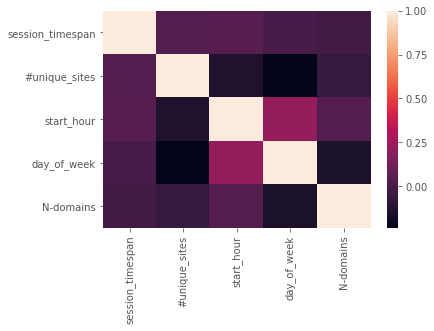

In [53]:
feature = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'N-domains', 'max domain']

sns.heatmap(df_fe[feature].corr())

На тепловой карте хорошо видно что нет признаков с высокой корреляцией поэтому для дальнейшей работы оставим их все.
Построим гистограммы распределения признаков для каждого пользователя.

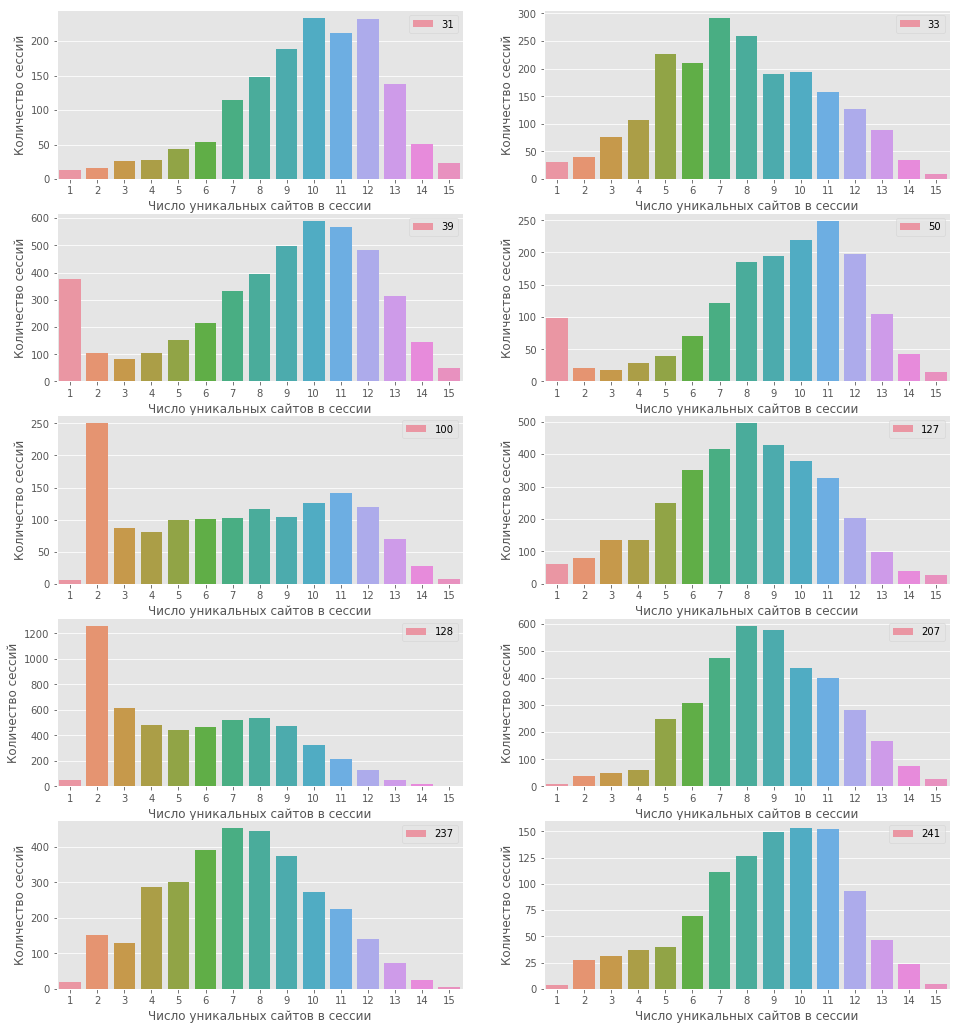

In [38]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 18))
axes = axes.ravel()

for idx, (user, sub_df) in  enumerate(pd.groupby(df_fe, 'target')):
    train_data_current_user = df_fe[df_fe.target == user]
    ax = sns.countplot(x = '#unique_sites', data = train_data_current_user, ax=axes[idx], label = user)
    ax.set(xlabel=u'Число уникальных сайтов в сессии', ylabel=u'Количество сессий')
    ax.legend()   

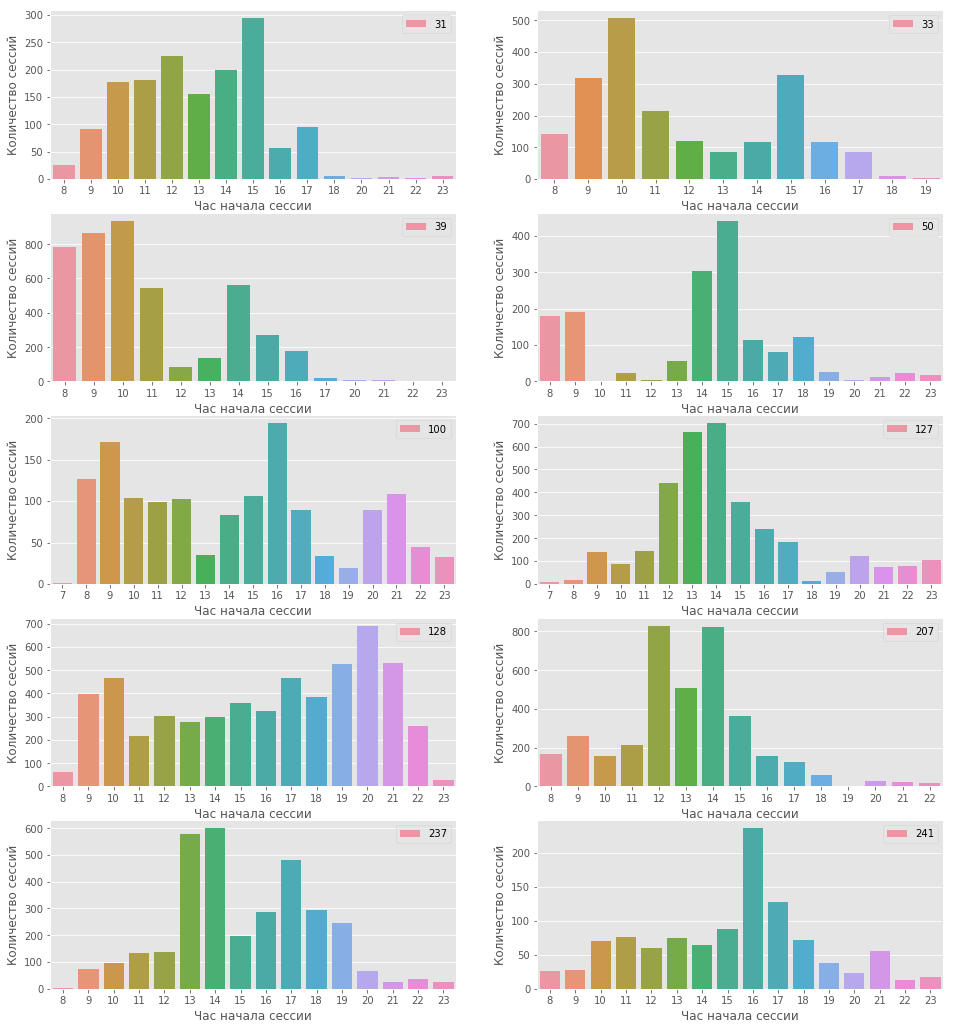

In [39]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 18))
axes = axes.ravel()

for idx, (user, sub_df) in  enumerate(pd.groupby(df_fe, 'target')):
    train_data_current_user = df_fe[df_fe.target == user]
    ax = sns.countplot(x = 'start_hour', data = train_data_current_user, ax=axes[idx], label = user)
    ax.set(xlabel=u'Час начала сессии', ylabel=u'Количество сессий')
    ax.legend()   

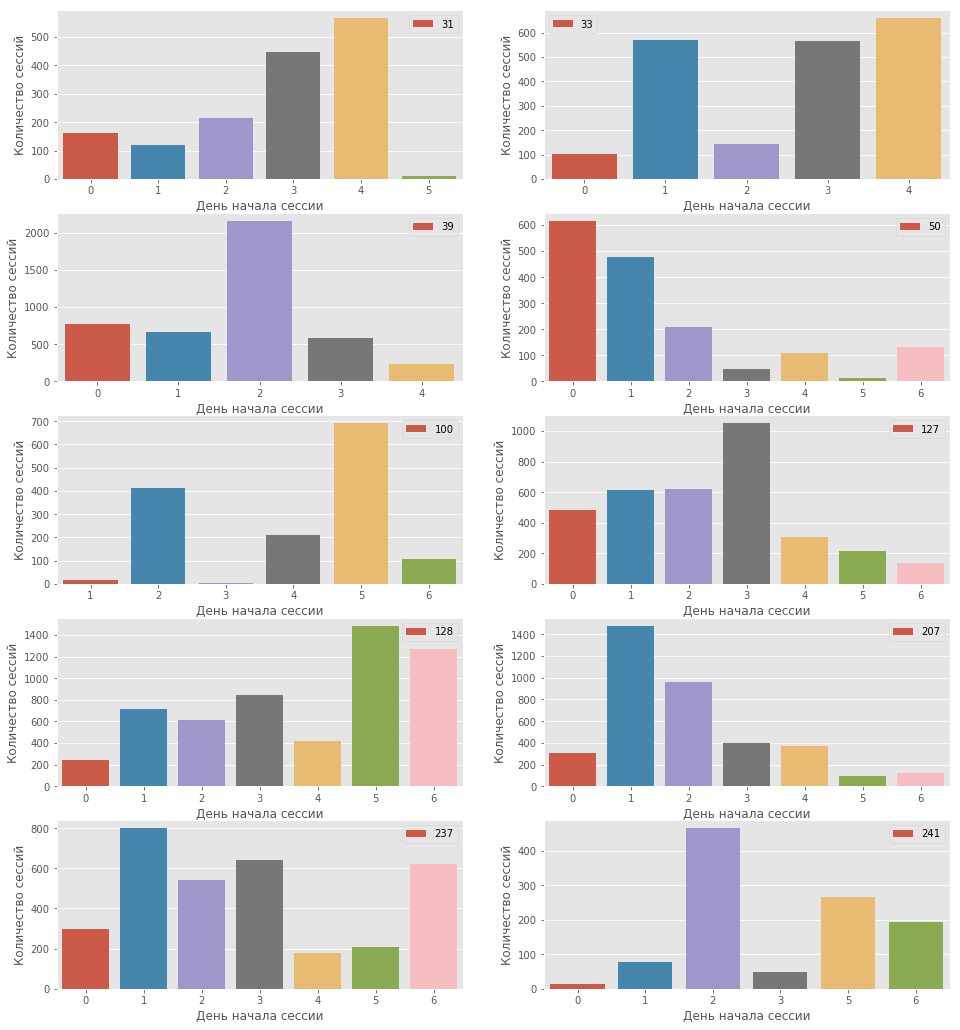

In [40]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(16, 18))
axes = axes.ravel()

for idx, (user, sub_df) in  enumerate(pd.groupby(df_fe, 'target')):
    train_data_current_user = df_fe[df_fe.target == user]
    ax = sns.countplot(x = 'day_of_week', data = train_data_current_user, ax=axes[idx], label = user)
    ax.set(xlabel=u'День начала сессии', ylabel=u'Количество сессий')
    ax.legend()   

# 4. Обучение финальной моделей

Дополнительный признаки сформированы, попробуем пвторно обучить наши модели и посмотрим на результат. Переведем данные в разреженый формат и соберем все в единую матрицу и не забудем нормализовать. 

In [87]:
df_fe_sparse = matrix(df_fe[['site' + str(i) for i in range(1,16)]].values)
feat = df_fe[['time_diff' + str(j) for j in range(1,15)] + ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week', 'N-domains']]
feat_sparse = sp.csr_matrix(feat.to_sparse())

In [88]:
df_fe_sparse = sp.hstack([df_fe_sparse, tf_cv_sparse, feat_sparse], format = 'csr')
norm_sparse = normalize(df_fe_sparse, axis=0)

In [89]:
X_train, X_valid, y_train, y_valid = train_test_split(norm_sparse, y_15_5, 
                                                      test_size=0.3, 
                                                     random_state=17, stratify=y_15_5)

In [90]:
%%time

scores = cross_val_score(estimator, X_train, y_train, scoring='accuracy', cv=skf, n_jobs=3)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_valid)
acc = accuracy_score(y_valid, y_pred)
print('Результат на кросс-валидации: {} , на тестовой выборке: {}'.format(np.mean(scores), acc))

Результат на кросс-валидации: 0.91423646309 , на тестовой выборке: 0.953413940256
Wall time: 47.2 s


# 5. Итоги

Итоговая модель показала на тестовой выборке результат 0.953. Что значит мы можем с точностью в 95% определить владельца аккаунта и отличить его от злоумышленика. Это хороший результат. Его можно еще улучшить. Для этого можно увеличить размер выборки, попробовать сгенерировать новые допонительные признаки. Попробовать какие то более сложные  алгоритмы классификации. Но для этого нужен доступ к большим вычислительным мощностям. Так же можно попробовать Blending, для этого надо обучить несколько различных моделей получить у них вероятности отнесения к целевому классу и затем усреднить. 